In [1]:
import pandas as pd 
import numpy as np 
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('dataset.csv',index_col=0)

# Prepare data

In [4]:
df.drop(['date_install','first_command_time','birthday','sex','time_confirm_email'],axis=1,inplace=True)

In [5]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
int_cols = int_cols.drop('target_game_currency')
obj_cols = ['country','network_name']

In [6]:
def prepare_obj_data(df, obj_cols):
    '''
    Подготовка колонок с типом данных object
    
    Args:
        df: pd.DataFrame
        obj_cols: list of str 
    Returns:
        pd.DataFrame
    '''
    
    cheat_count_is_cheater = df['is_cheater'].value_counts().index[0]
    cheat_count_has_email = df['has_email'].value_counts().index[0]
    
    df['is_cheater'] = df['is_cheater'].fillna(cheat_count_is_cheater)
    df['has_email'] = df['has_email'].fillna(cheat_count_has_email)
    
    df['country'] = df['country'].fillna('other')
    df['network_name'] = df['network_name'].fillna('other')

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for column in obj_cols:
        encoded_data = encoder.fit_transform(df[[column]])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
    
    df.drop(obj_cols, axis=1, inplace=True)
        
    return df


In [7]:
df = prepare_obj_data(df, obj_cols)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
X = df.drop('target_game_currency', axis = 1)
y = np.log(df['target_game_currency']+1)

In [9]:
y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y_stratified, random_state=42)


In [10]:
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

Будем решать задачу классификации для определения людей которые платят. После того как определили кто заплатил, решаем задачу регрессии

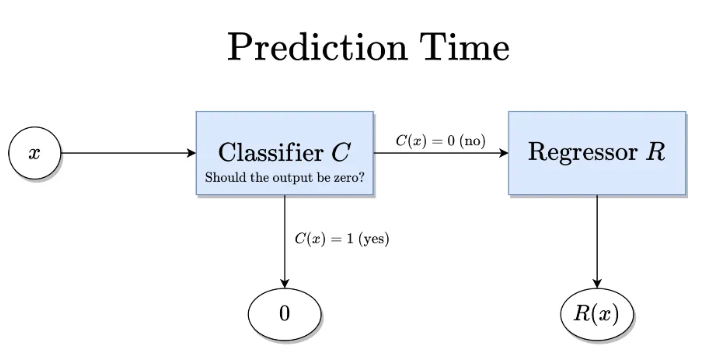

## Classification

In [11]:
def plot_importance(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importances_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [12]:
def plot_importance_reg(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.coef_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [13]:
def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)


def custom_smape_score(estimator, X, y):
    '''
    SMAP for cross-validation
    '''
    y_pred = estimator.predict(X)
    smape = SMAPE(y, y_pred)
    return -smape

In [14]:
def train_model(model_obj, X_train, y_train, num_folds ,scoring, cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

In [15]:
def train_model_reg(model_obj, X_train, y_train, num_folds ,scoring, cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train, verbose=50))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

Learning rate set to 0.104069
0:	learn: 0.4945940	total: 85.2ms	remaining: 1m 25s
1:	learn: 0.3672890	total: 110ms	remaining: 54.7s
2:	learn: 0.2777376	total: 133ms	remaining: 44.3s
3:	learn: 0.2168453	total: 161ms	remaining: 40.1s
4:	learn: 0.1727505	total: 187ms	remaining: 37.3s
5:	learn: 0.1433905	total: 213ms	remaining: 35.2s
6:	learn: 0.1246077	total: 238ms	remaining: 33.7s
7:	learn: 0.1104373	total: 265ms	remaining: 32.8s
8:	learn: 0.1017053	total: 291ms	remaining: 32.1s
9:	learn: 0.0955205	total: 317ms	remaining: 31.4s
10:	learn: 0.0892147	total: 346ms	remaining: 31.1s
11:	learn: 0.0848101	total: 375ms	remaining: 30.9s
12:	learn: 0.0824167	total: 410ms	remaining: 31.1s
13:	learn: 0.0796924	total: 464ms	remaining: 32.7s
14:	learn: 0.0778121	total: 507ms	remaining: 33.3s
15:	learn: 0.0760769	total: 559ms	remaining: 34.4s
16:	learn: 0.0749366	total: 612ms	remaining: 35.4s
17:	learn: 0.0739001	total: 663ms	remaining: 36.2s
18:	learn: 0.0733195	total: 704ms	remaining: 36.3s
19:	learn

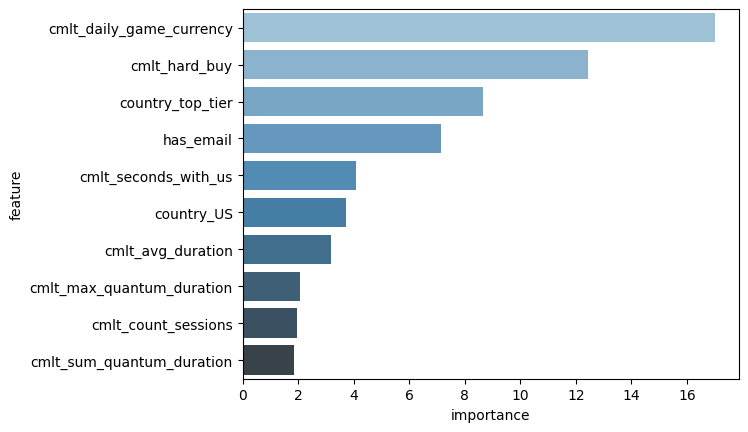

In [16]:
params = {
    'iterations': 200,
    'depth': 3,
    'loss_function': 'RMSE',
    'random_state': 42,
    'l2_leaf_reg': 20,
    'verbose': 50,
    'early_stopping_rounds': 20 
}

model, features = train_model(CatBoostClassifier(),
                              X_train, 
                              y_train_binary,
                              5,
                              scoring='roc_auc',
                              cross_val=True)

In [18]:
X_train_regression = X_train[y_train_binary == 1]
y_train_regression = y_train[y_train_binary == 1]

0:	learn: 2.1796498	total: 2.8ms	remaining: 1.4s
50:	learn: 1.8686393	total: 85.2ms	remaining: 750ms
100:	learn: 1.8133922	total: 178ms	remaining: 703ms
150:	learn: 1.7946055	total: 388ms	remaining: 898ms
200:	learn: 1.7840017	total: 518ms	remaining: 771ms
250:	learn: 1.7753987	total: 621ms	remaining: 616ms
300:	learn: 1.7690080	total: 701ms	remaining: 464ms
350:	learn: 1.7639074	total: 794ms	remaining: 337ms
400:	learn: 1.7607153	total: 912ms	remaining: 225ms
450:	learn: 1.7570534	total: 1.04s	remaining: 113ms
499:	learn: 1.7537448	total: 1.16s	remaining: 0us
0:	learn: 2.1848191	total: 4.04ms	remaining: 2.02s
50:	learn: 1.8723545	total: 137ms	remaining: 1.2s
100:	learn: 1.8142896	total: 261ms	remaining: 1.03s
150:	learn: 1.7964157	total: 363ms	remaining: 840ms
200:	learn: 1.7846350	total: 515ms	remaining: 767ms
250:	learn: 1.7742272	total: 623ms	remaining: 618ms
300:	learn: 1.7671279	total: 721ms	remaining: 477ms
350:	learn: 1.7615207	total: 809ms	remaining: 344ms
400:	learn: 1.758028

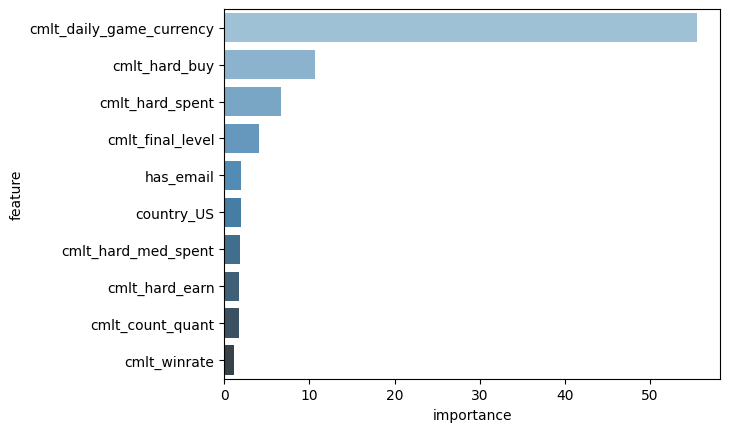

In [37]:
params = {
    'iterations': 500,
    'depth': 3,
    'loss_function': 'RMSE',
    'random_state': 42,
    'l2_leaf_reg': 20,
    'verbose': 50,
    'early_stopping_rounds': 20 
}

model_reg, features_reg = train_model_reg(CatBoostRegressor(**params),
                              X_train_regression, 
                              y_train_regression,
                              5,
                              scoring='neg_mean_squared_error',
                              cross_val=True)

In [38]:
y_pred_train_binary = model.predict(X_train)
y_pred_test_binary = model.predict(X_test)

In [39]:
y_pred_train_regression = model_reg.predict(X_train_regression)
y_pred_test_regression = model_reg.predict(X_test[y_test_binary == 1])

In [40]:
smape_train_classification = SMAPE(y_train_binary, y_pred_train_binary)
smape_test_classification = SMAPE(y_test_binary, y_pred_test_binary)


In [41]:
smape_train_regression = SMAPE(y_train_regression, y_pred_train_regression)
smape_test_regression = SMAPE(y_test[y_test_binary == 1], y_pred_test_regression) 

mse_train = mean_squared_error(y_train_regression, y_pred_train_regression)
mse_test = mean_squared_error(y_test[y_test_binary == 1], y_pred_test_regression)

rmse_train = sqrt(mse_train)
rmse_test = sqrt(mse_test)


In [42]:
print(f"SMAPE for train data (classification): {smape_train_classification}")
print(f"SMAPE for test data (classification): {smape_test_classification}")


print(f"SMAPE for train data (regression): {smape_train_regression}")
print(f"SMAPE for test data (regression): {smape_test_regression}")

print(f"MSE for train data: {mse_train}")
print(f"MSE for test data: {mse_test}")

print(f"RMSE for train data: {rmse_train}")
print(f"RMSE for test data: {rmse_test}")


SMAPE for train data (classification): 0.03068376258305371
SMAPE for test data (classification): 0.03479860805567777
SMAPE for train data (regression): 0.20734529916136593
SMAPE for test data (regression): 0.21151788910628816
MSE for train data: 3.075621092620266
MSE for test data: 3.0852013761949317
RMSE for train data: 1.753744876719606
RMSE for test data: 1.7564741319458512


In [43]:
# Exponentiate predictions and true values to original scale
y_train_regression_orig = np.exp(y_train_regression) - 1
y_pred_train_regression_orig = np.exp(y_pred_train_regression) - 1

y_test_regression_orig = np.exp(y_test[y_test_binary == 1]) - 1
y_pred_test_regression_orig = np.exp(y_pred_test_regression) - 1

# Now calculate metrics on this original scale
smape_train_regression_orig = SMAPE(y_train_regression_orig, y_pred_train_regression_orig)
smape_test_regression_orig = SMAPE(y_test_regression_orig, y_pred_test_regression_orig)

mse_train_orig = mean_squared_error(y_train_regression_orig, y_pred_train_regression_orig)
mse_test_orig = mean_squared_error(y_test_regression_orig, y_pred_test_regression_orig)

rmse_train_orig = sqrt(mse_train_orig)
rmse_test_orig = sqrt(mse_test_orig)

print(f"SMAPE for train data (classification): {smape_train_classification}")
print(f"SMAPE for test data (classification): {smape_test_classification}")

print(f"SMAPE for train data (regression) [Original Scale]: {smape_train_regression_orig}")
print(f"SMAPE for test data (regression) [Original Scale]: {smape_test_regression_orig}")

print(f"MSE for train data [Original Scale]: {mse_train_orig}")
print(f"MSE for test data [Original Scale]: {mse_test_orig}")

print(f"RMSE for train data [Original Scale]: {rmse_train_orig}")
print(f"RMSE for test data [Original Scale]: {rmse_test_orig}")


SMAPE for train data (classification): 0.03068376258305371
SMAPE for test data (classification): 0.03479860805567777
SMAPE for train data (regression) [Original Scale]: 1.0877544825044945
SMAPE for test data (regression) [Original Scale]: 1.1064810132470002
MSE for train data [Original Scale]: 1758565096.6642454
MSE for test data [Original Scale]: 1356737809.0746965
RMSE for train data [Original Scale]: 41935.248856591345
RMSE for test data [Original Scale]: 36833.92198876868
